In [72]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
import keras_tuner
from sklearn.metrics import mean_squared_error
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers


# Loading data #

In [100]:
df = pd.read_csv("A.csv")

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5804 entries, 0 to 5803
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            5804 non-null   object 
 1   Low             5804 non-null   float64
 2   Open            5804 non-null   float64
 3   Volume          5804 non-null   int64  
 4   High            5804 non-null   float64
 5   Close           5804 non-null   float64
 6   Adjusted Close  5804 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 317.5+ KB


In [87]:
df


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,18-11-1999,28.612303,32.546494,62546380,35.765381,31.473534,27.066582
1,19-11-1999,28.478184,30.713518,15234146,30.758226,28.880545,24.836662
2,22-11-1999,28.657009,29.551144,6577870,31.473534,31.473534,27.066582
3,23-11-1999,28.612303,30.400572,5975611,31.205294,28.612303,24.605980
4,24-11-1999,28.612303,28.701717,4843231,29.998213,29.372318,25.259573
...,...,...,...,...,...,...,...
5799,06-12-2022,149.910004,152.149994,1172300,153.000000,151.350006,151.350006
5800,07-12-2022,151.130005,151.229996,1011100,154.350006,153.729996,153.729996
5801,08-12-2022,153.479996,154.419998,1289900,156.990005,156.279999,156.279999
5802,09-12-2022,152.679993,155.669998,1020200,156.699997,152.949997,152.949997


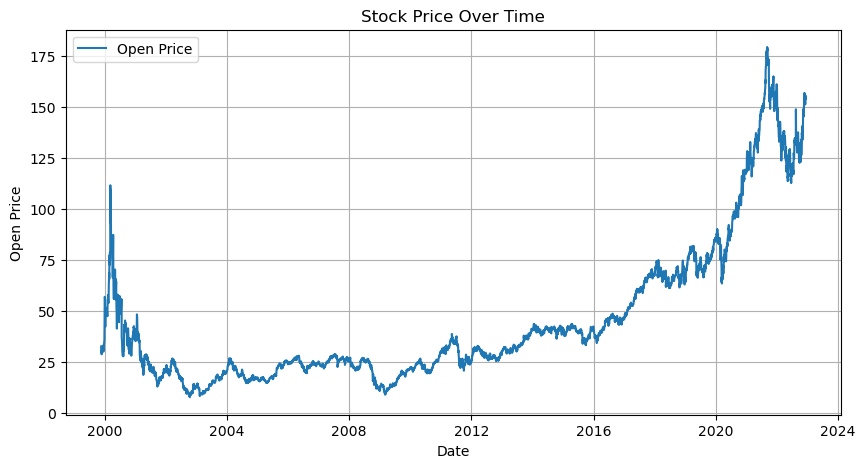

In [102]:

# Convert the 'Date' column to datetime objects with the correct format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Plot the 'Open' column over time
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Open'], label='Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

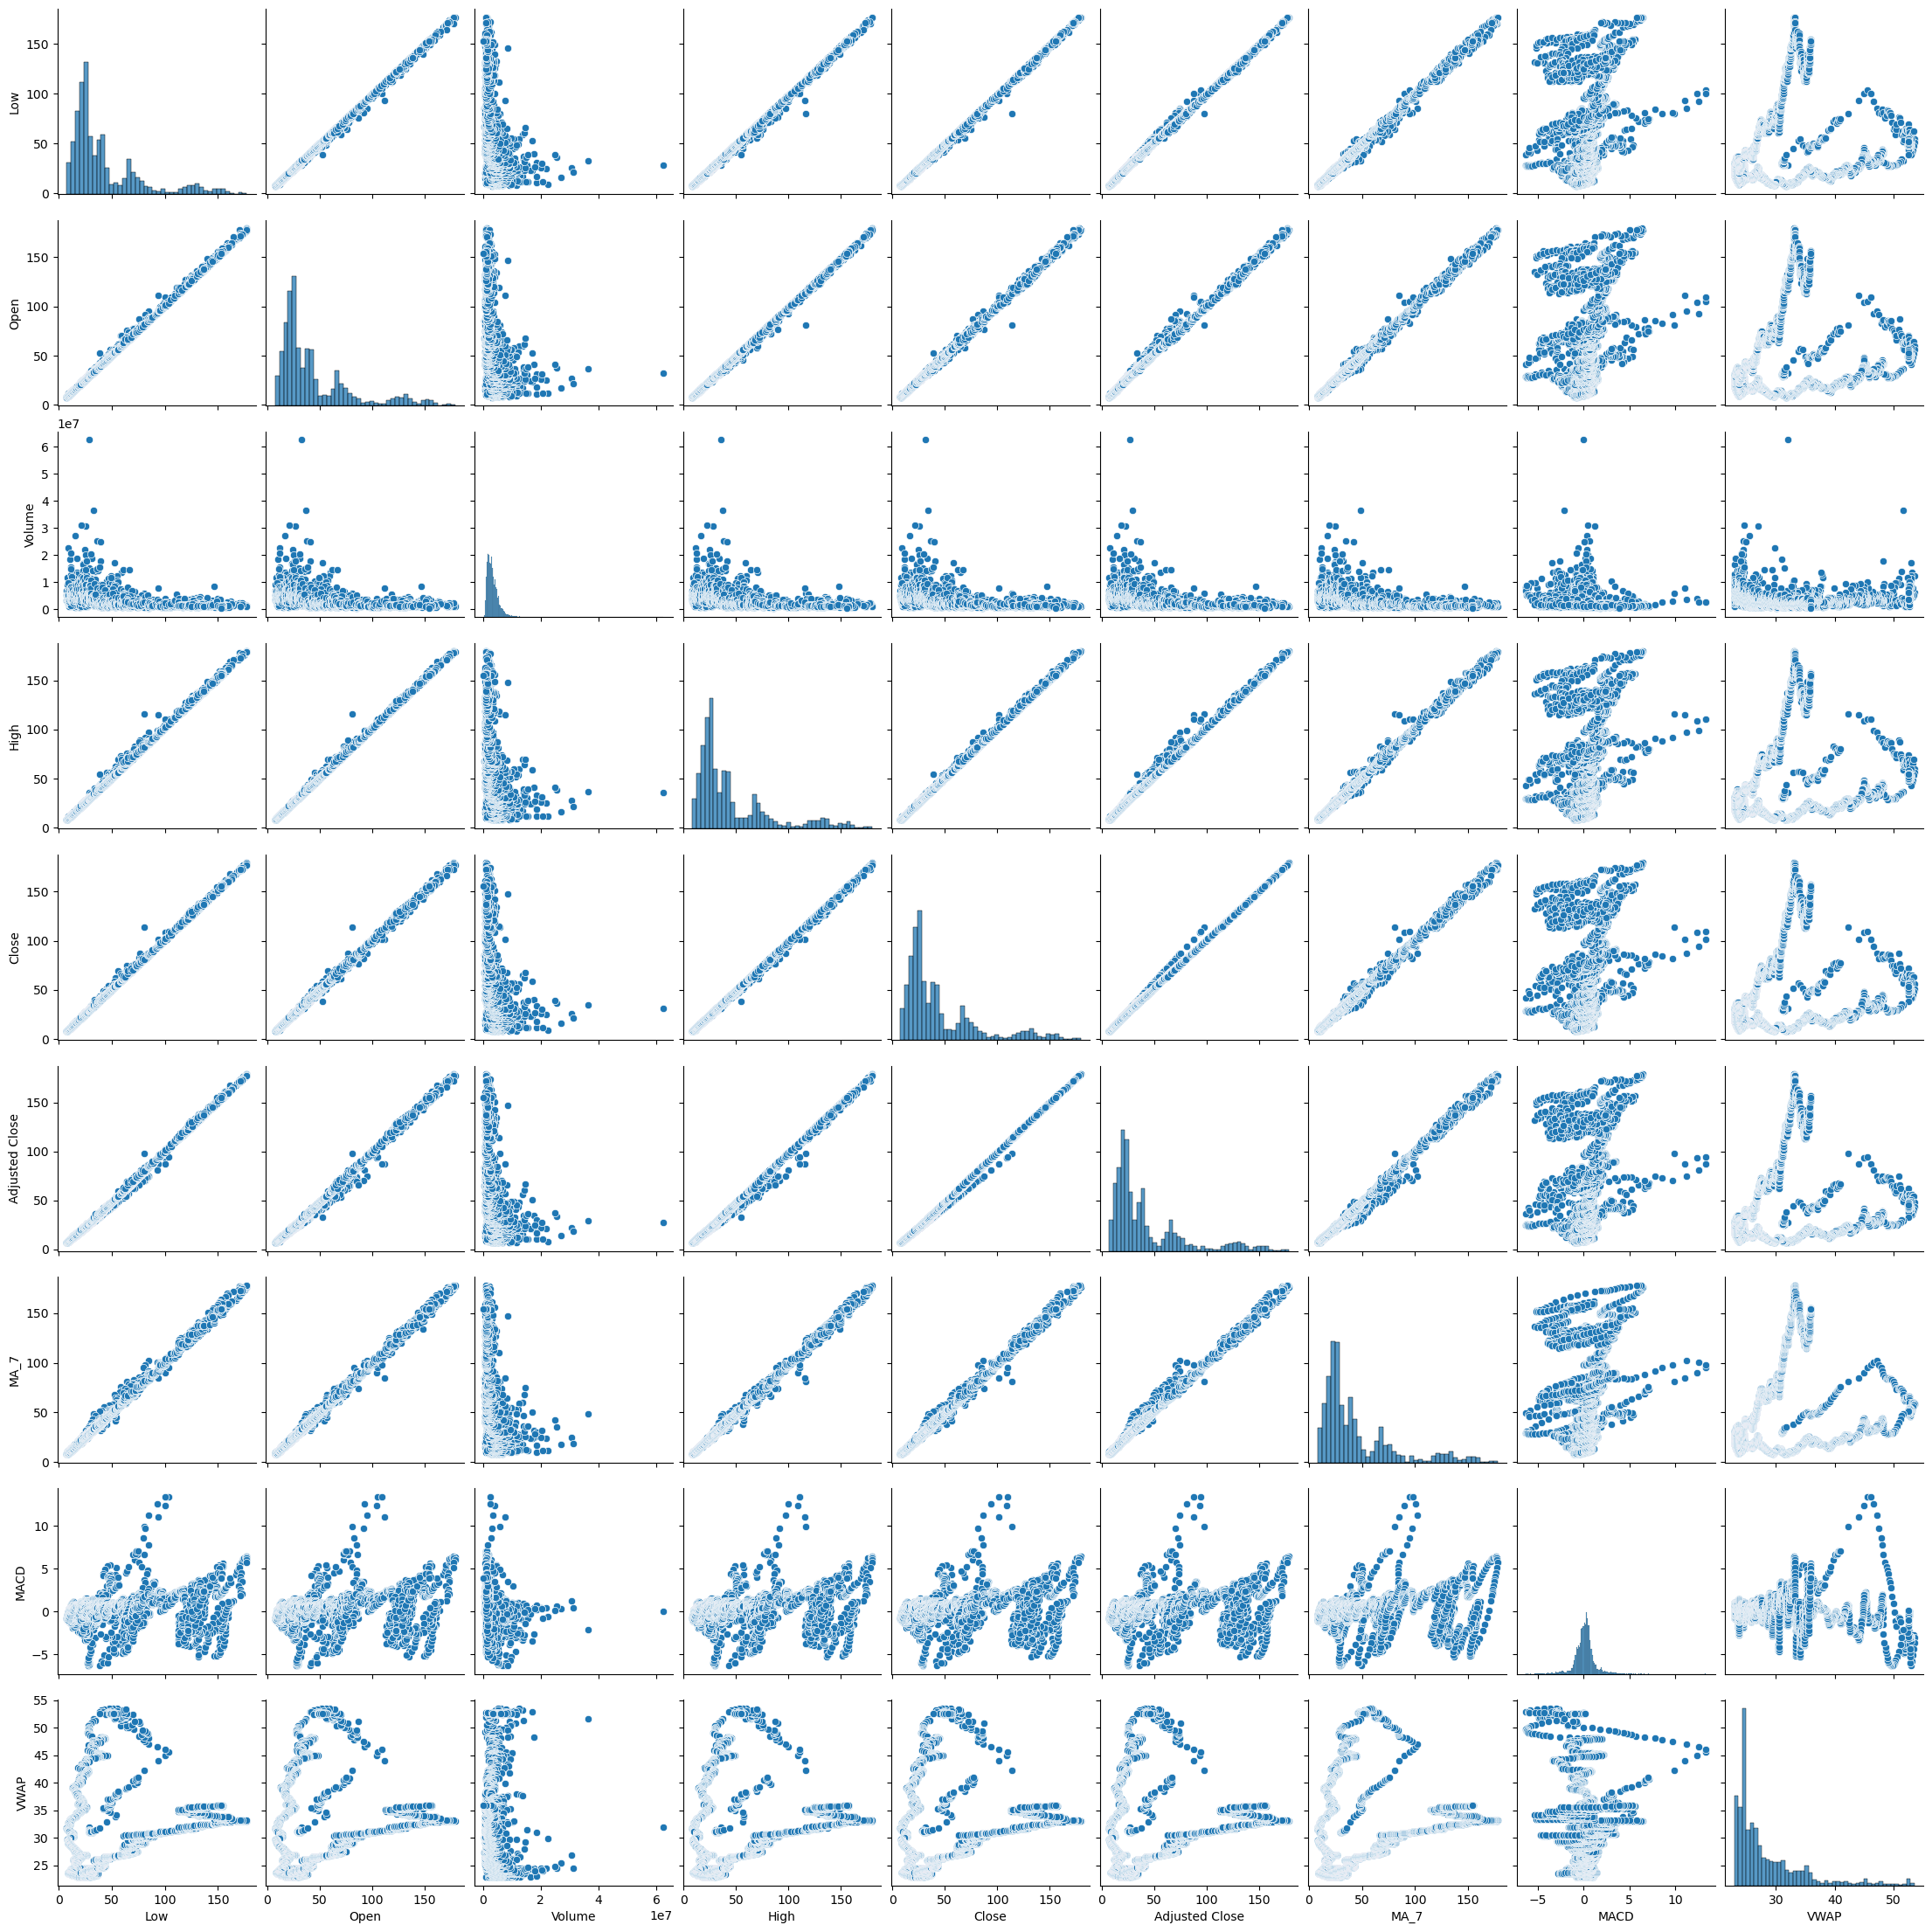

In [103]:
import seaborn as sns

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Moving Averages
df['MA_7'] = df['Close'].rolling(window=7).mean()

# MACD (Moving Average Convergence Divergence)
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()


# Volume-Weighted Average Price (VWAP)
df['VWAP'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum()


# Create a pairplot
sns.pairplot(df)
plt.show()

In [104]:
# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year, month, and day as separate columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Drop the original 'Date' column
df = df.drop(columns=['Date'])

df = df.dropna()

# Separate features and target
features = df.drop(columns=['Close']).values  # All columns except 'Close'
target = df['Close'].values  # Target column

# Scale features
feature_scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = feature_scaler.fit_transform(features)

# Scale target
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(target.reshape(-1, 1))

# Combine scaled features and target for sequence generation
df_scaled = np.hstack((features_scaled, target_scaled))

# Split the data into training and testing sets
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size,:], df_scaled[train_size:len(df_scaled),:]

In [105]:
# Define the sequence generation function
def create_sequences(data, t):
    """
    Create sequences of t timesteps for LSTM training.
    
    Parameters:
    - data: Scaled dataset (numpy array).
    - t: Number of timesteps in each sequence.
    
    Returns:
    - X: Input sequences of shape (samples, t, features).
    - y: Target values for each sequence.
    """
    X, y = [], []
    for i in range(len(data) - t - 1):
        X.append(data[i:(i + t), :-1])  # All features except target
        y.append(data[i + t, -1])      # Target column (Close price)
    return np.array(X), np.array(y)

# Create sequences of t timesteps
t = 20  # Sequence length (timesteps)
X_train, y_train = create_sequences(train, t)
X_test, y_test = create_sequences(test, t)

In [106]:
# Build the LSTM model
model = Sequential([
    Input(shape=(t, X_train.shape[2])),
    LSTM(50, activation='tanh'),
    Dense(1, activation='linear')  # Single output for predicting 'Close'
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0067 - val_loss: 0.0020
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6755e-04 - val_loss: 6.7453e-04
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4646e-04 - val_loss: 8.8001e-04
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4236e-04 - val_loss: 5.1891e-04
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0315e-04 - val_loss: 0.0012
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.6225e-05 - val_loss: 0.0010
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.9545e-05 - val_loss: 0.0012
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.3779e-05 - val_loss: 0.0011
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.3935e-05 - val_loss: 2.3199e-04
Epoch 10/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.3923e-05 - val_loss: 4.8142e-04
Epoch 11/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7004e-05 - val_loss:

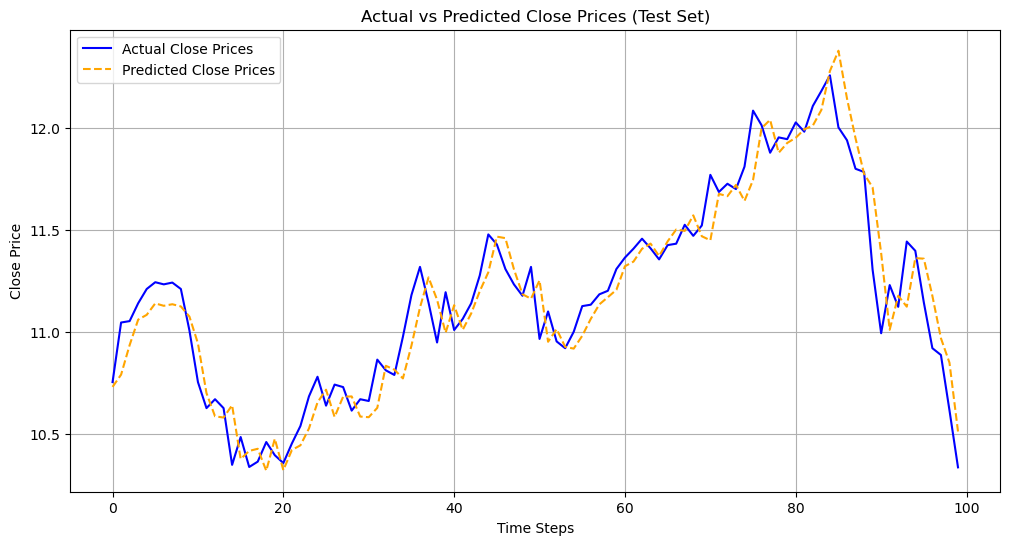

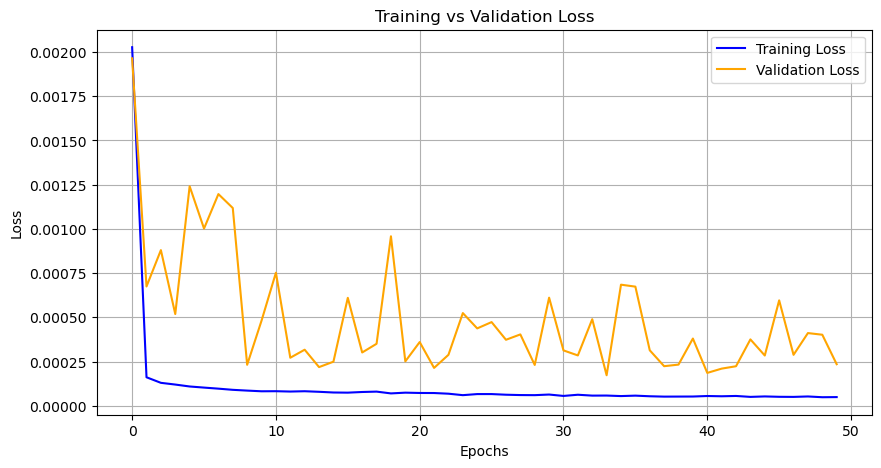

In [107]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")

# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform predictions and true values for comparison
y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], df_scaled.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1]
y_pred_actual = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], df_scaled.shape[1] - 1)), y_pred)))[:, -1]

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:100], label="Actual Close Prices", color="blue")
plt.plot(y_pred_actual[:100], label="Predicted Close Prices", color="orange", linestyle="--")
plt.title("Actual vs Predicted Close Prices (Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Training Loss", color="blue")
plt.plot(history.history['val_loss'], label="Validation Loss", color="orange")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Data Preprocessing #

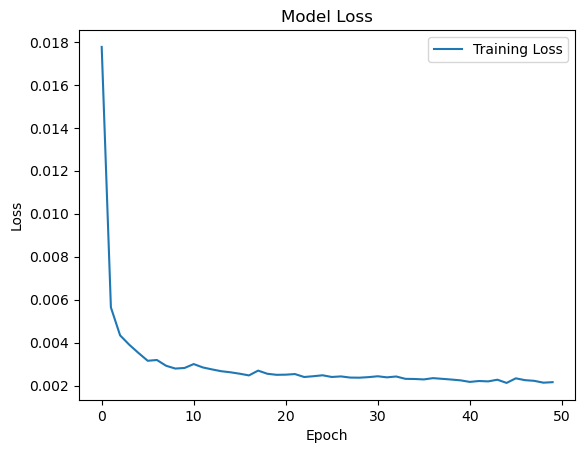

In [93]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [95]:
# Test the model
test_error = model.evaluate(X_test, y_test, verbose=2)
print(f'Test error: {test_error}')
print(f'Accuracy: {(1-test_error) * 100}%')


36/36 - 0s - 2ms/step - loss: 0.0032
Test error: 0.0032052716705948114
Accuracy: 99.67947283294052%


In [98]:
# Make predictions
predictions = model.predict(X_test)

# Reshape and inverse transform
predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Align dates
test_start_index = train_size + sequence_length
test_dates = df['Date'].iloc[test_start_index:test_start_index + len(y_test)].reset_index(drop=True)

# Create result DataFrame
result_df = pd.DataFrame({
    'Date': pd.to_datetime(test_dates),
    'Actual': y_test_inverse.flatten(),
    'Predicted': predictions_inverse.flatten()
})

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))
plt.plot(result_df['Date'], result_df['Actual'], color='blue', label='Actual Stock Price')
plt.plot(result_df['Date'], result_df['Predicted'], color='red', label='Predicted Stock Price')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


ValueError: non-broadcastable output operand with shape (13668,1) doesn't match the broadcast shape (13668,12)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5798 entries, 6 to 5803
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Low             5798 non-null   float64
 1   Open            5798 non-null   float64
 2   Volume          5798 non-null   int64  
 3   High            5798 non-null   float64
 4   Close           5798 non-null   float64
 5   Adjusted Close  5798 non-null   float64
 6   MA_7            5798 non-null   float64
 7   MACD            5798 non-null   float64
 8   VWAP            5798 non-null   float64
 9   Year            5798 non-null   int32  
 10  Month           5798 non-null   int32  
 11  Day             5798 non-null   int32  
dtypes: float64(8), int32(3), int64(1)
memory usage: 520.9 KB


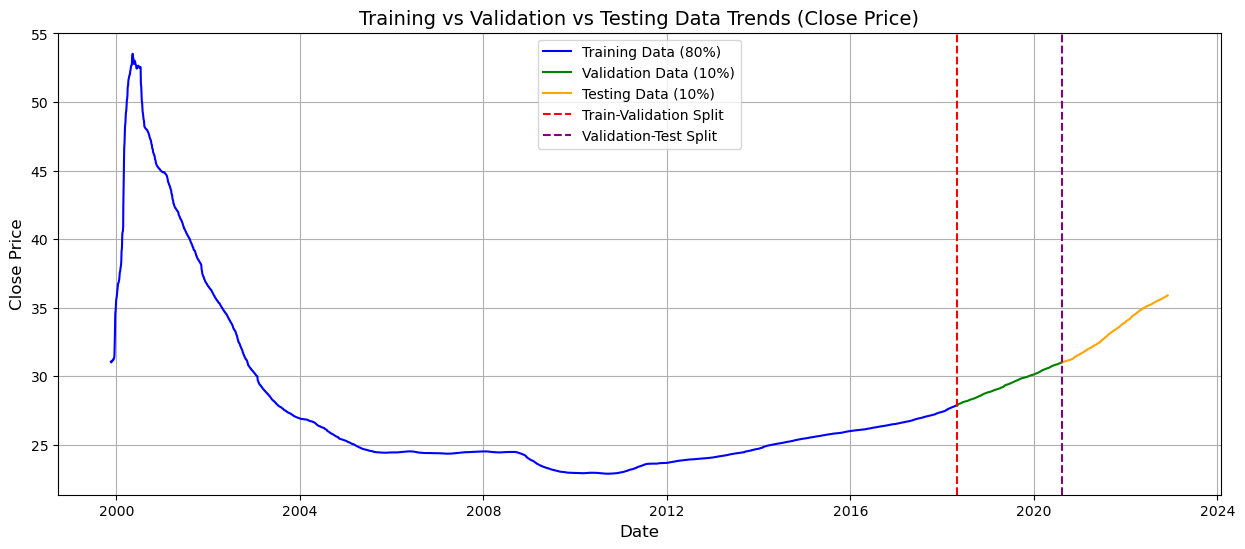

In [67]:

# Preprocess the numerical columns
numerical_columns = df.drop(columns=['Date'])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(numerical_columns)

# Add back the 'Date' column for visualization
scaled_df = pd.DataFrame(scaled_data, columns=numerical_columns.columns)
scaled_df['Date'] = date_column

# Split the data into training (80%), validation (10%), and test (10%) sets
train_size = int(len(scaled_df) * 0.8)  # 80% for training
val_size = int(len(scaled_df) * 0.1)    # 10% for validation
test_size = len(scaled_df) - train_size - val_size

train = scaled_df.iloc[:train_size]
val = scaled_df.iloc[train_size:train_size + val_size]
test = scaled_df.iloc[train_size + val_size:]

# Define the function to create sequences
def create_sequences(data, t):
    X, y = [], []
    for i in range(len(data) - t - 1):
        X.append(data[i:(i + t), :-1])  # All columns except 'Date'
        y.append(data[i + t, -1])      # Predict the 'Close' price (last column)
    return np.array(X), np.array(y)

# Sequence length (timesteps)
t = 10

# Prepare the data for training
train_data = train.drop(columns=['Date']).values
val_data = val.drop(columns=['Date']).values
test_data = test.drop(columns=['Date']).values

X_train, y_train = create_sequences(train_data, t)
X_val, y_val = create_sequences(val_data, t)
X_test, y_test = create_sequences(test_data, t)


# Extract 'Date' and 'Close' columns for each dataset
train_dates = train['Date']
val_dates = val['Date']
test_dates = test['Date']

train_close = scaler.inverse_transform(train.drop(columns=['Date']).values)[:, -1]  # Rescale 'Close' column for training
val_close = scaler.inverse_transform(val.drop(columns=['Date']).values)[:, -1]      # Rescale 'Close' column for validation
test_close = scaler.inverse_transform(test.drop(columns=['Date']).values)[:, -1]    # Rescale 'Close' column for testing

# Plot training, validation, and testing trends
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train_dates, train_close, label="Training Data (80%)", color="blue")

# Plot validation data
plt.plot(val_dates, val_close, label="Validation Data (10%)", color="green")

# Plot testing data
plt.plot(test_dates, test_close, label="Testing Data (10%)", color="orange")

# Mark splits with vertical lines
plt.axvline(x=train_dates.iloc[-1], color="red", linestyle="--", label="Train-Validation Split")
plt.axvline(x=val_dates.iloc[-1], color="purple", linestyle="--", label="Validation-Test Split")

# Add title, labels, and legend
plt.title("Training vs Validation vs Testing Data Trends (Close Price)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Display the plot
plt.show()



# Vanilla RNN Implementation #

Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1183 - val_loss: 0.0032
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0454 - val_loss: 0.0026
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0345 - val_loss: 0.0760
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0277 - val_loss: 0.0034
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0234 - val_loss: 0.0225
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175 - val_loss: 0.0052
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0184 - val_loss: 0.0235
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - val_loss: 0.0305
Epoch 9/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - val_loss: 0.0111
Epoch 10/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0162 - val_loss: 0.0117
Epoch 11/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 - val_loss: 0.0058
Epoch 12/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

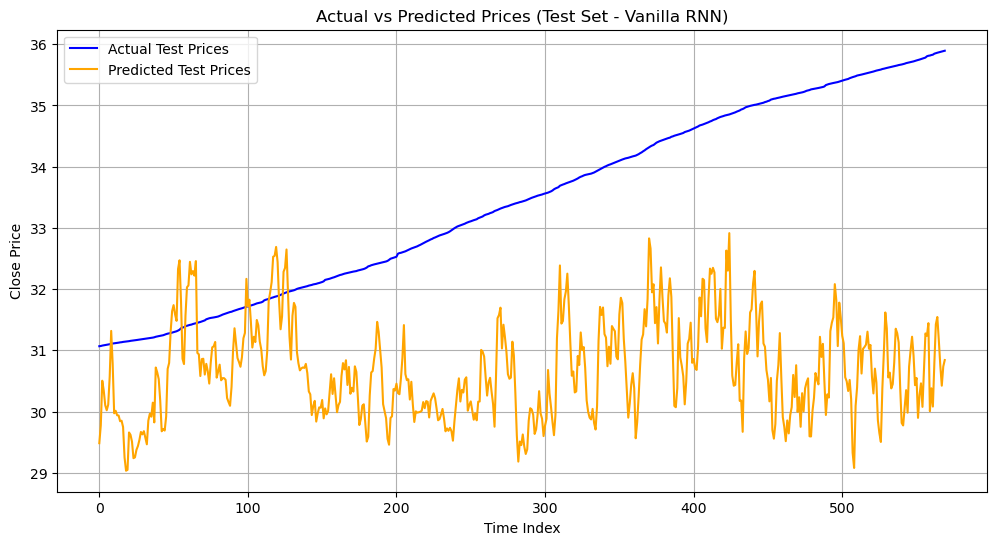

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error
import math

# Build the Vanilla RNN model
model = Sequential([
    Input(shape=(t, X_train.shape[2])),  # Define input shape explicitly
    SimpleRNN(50, return_sequences=False),  # Vanilla RNN with 50 units
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Make predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
train_actual = scaler.inverse_transform(np.hstack((train_data[t:-1, :-1], y_train.reshape(-1, 1))))[:, -1]
train_predictions_rescaled = scaler.inverse_transform(np.hstack((train_data[t:-1, :-1], train_predictions)))[:, -1]

val_actual = scaler.inverse_transform(np.hstack((val_data[t:-1, :-1], y_val.reshape(-1, 1))))[:, -1]
val_predictions_rescaled = scaler.inverse_transform(np.hstack((val_data[t:-1, :-1], val_predictions)))[:, -1]

test_actual = scaler.inverse_transform(np.hstack((test_data[t:-1, :-1], y_test.reshape(-1, 1))))[:, -1]
test_predictions_rescaled = scaler.inverse_transform(np.hstack((test_data[t:-1, :-1], test_predictions)))[:, -1]

# Calculate RMSE for each dataset
train_rmse = math.sqrt(mean_squared_error(train_actual, train_predictions_rescaled))
val_rmse = math.sqrt(mean_squared_error(val_actual, val_predictions_rescaled))
test_rmse = math.sqrt(mean_squared_error(test_actual, test_predictions_rescaled))

# Print RMSE for each dataset
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# Plot actual vs predicted values for the test dataset
plt.figure(figsize=(12, 6))
plt.plot(test_actual, label="Actual Test Prices", color="blue")
plt.plot(test_predictions_rescaled, label="Predicted Test Prices", color="orange")
plt.title("Actual vs Predicted Prices (Test Set - Vanilla RNN)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


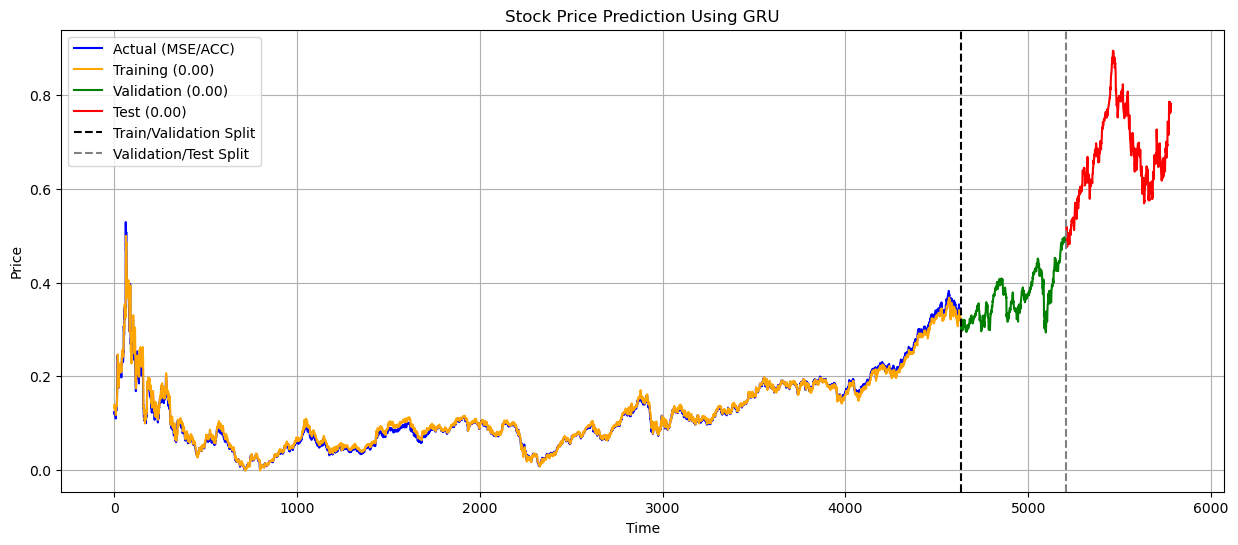

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Generate dummy predictions for visualization purposes
# Replace these with actual predictions from your trained GRU or RNN model
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test[:len(X_test) // 2])  # Split test for validation
test_predictions = model.predict(X_test[len(X_test) // 2:])

# Combine the actual values
train_actual = y_train
val_actual = y_test[:len(X_test) // 2]
test_actual = y_test[len(X_test) // 2:]

# Calculate metrics
train_mse = mean_squared_error(train_actual, train_predictions)
val_mse = mean_squared_error(val_actual, val_predictions)
test_mse = mean_squared_error(test_actual, test_predictions)

# Create the plot
plt.figure(figsize=(15, 6))

# Plot actual values
plt.plot(np.arange(len(train_actual)), train_actual, color="blue", label="Actual (MSE/ACC)")

# Plot predictions
plt.plot(np.arange(len(train_predictions)), train_predictions, color="orange", label=f"Training ({train_mse:.2f})")
plt.plot(
    np.arange(len(train_predictions), len(train_predictions) + len(val_predictions)),
    val_predictions,
    color="green",
    label=f"Validation ({val_mse:.2f})"
)
plt.plot(
    np.arange(len(train_predictions) + len(val_predictions),
              len(train_predictions) + len(val_predictions) + len(test_predictions)),
    test_predictions,
    color="red",
    label=f"Test ({test_mse:.2f})"
)

# Annotate
plt.axvline(x=len(train_actual), color="black", linestyle="--", label="Train/Validation Split")
plt.axvline(x=len(train_actual) + len(val_actual), color="gray", linestyle="--", label="Validation/Test Split")

# Labels and title
plt.title("Stock Price Prediction Using GRU")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0039 - val_loss: 2.4471e-04
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1071e-04 - val_loss: 8.6784e-04
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2413e-04 - val_loss: 0.0016
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6470e-04 - val_loss: 4.6353e-04
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2591e-04 - val_loss: 7.2698e-04
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9745e-04 - val_loss: 0.0012
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1376e-04 - val_loss: 6.1961e-04
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9223e-04 - val_loss: 0.0016
Epoch 9/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0558e-04 - val_loss: 0.0014
Epoch 10/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8429e-04 - val_loss: 7.8890e-04
Epoch 11/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4065e-04 - val_l

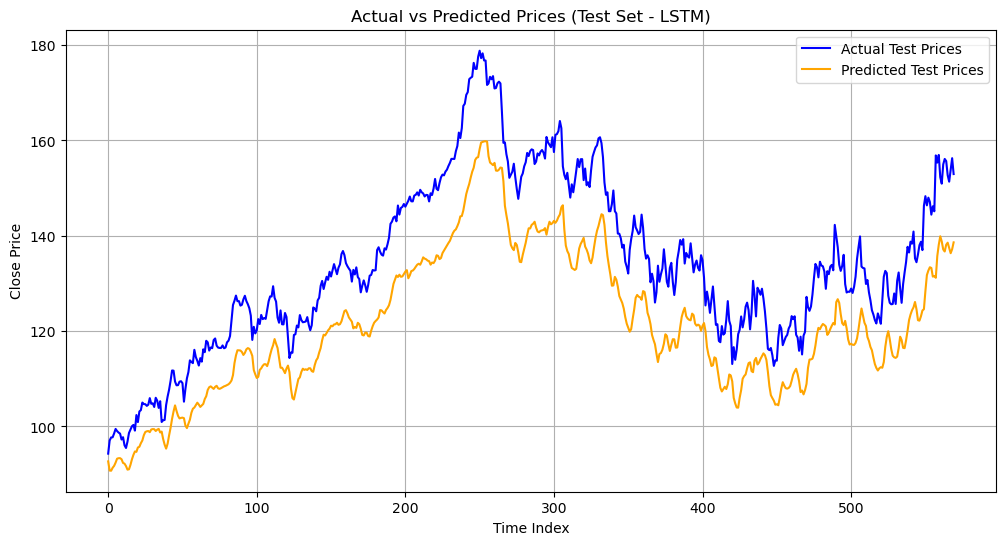

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error
import math

# Build the LSTM model
model = Sequential([
    Input(shape=(t, X_train.shape[2])),  # Define input shape explicitly
    LSTM(50, return_sequences=False),  # LSTM with 50 units
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Make predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
train_actual = scaler.inverse_transform(np.hstack((train_data[t:-1, :-1], y_train.reshape(-1, 1))))[:, -1]
train_predictions_rescaled = scaler.inverse_transform(np.hstack((train_data[t:-1, :-1], train_predictions)))[:, -1]

val_actual = scaler.inverse_transform(np.hstack((val_data[t:-1, :-1], y_val.reshape(-1, 1))))[:, -1]
val_predictions_rescaled = scaler.inverse_transform(np.hstack((val_data[t:-1, :-1], val_predictions)))[:, -1]

test_actual = scaler.inverse_transform(np.hstack((test_data[t:-1, :-1], y_test.reshape(-1, 1))))[:, -1]
test_predictions_rescaled = scaler.inverse_transform(np.hstack((test_data[t:-1, :-1], test_predictions)))[:, -1]

# Calculate RMSE for each dataset
train_rmse = math.sqrt(mean_squared_error(train_actual, train_predictions_rescaled))
val_rmse = math.sqrt(mean_squared_error(val_actual, val_predictions_rescaled))
test_rmse = math.sqrt(mean_squared_error(test_actual, test_predictions_rescaled))

# Print RMSE for each dataset
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# Plot actual vs predicted values for the test dataset
plt.figure(figsize=(12, 6))
plt.plot(test_actual, label="Actual Test Prices", color="blue")
plt.plot(test_predictions_rescaled, label="Predicted Test Prices", color="orange")
plt.title("Actual vs Predicted Prices (Test Set - LSTM)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0036 - val_loss: 4.5704e-04
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9447e-04 - val_loss: 7.5041e-04
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9432e-04 - val_loss: 5.1665e-04
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6120e-04 - val_loss: 3.0611e-04
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9402e-04 - val_loss: 0.0012
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8249e-04 - val_loss: 0.0010
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9605e-04 - val_loss: 4.9345e-04
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0360e-04 - val_loss: 8.1219e-04
Epoch 9/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4724e-04 - val_loss: 3.5403e-04
Epoch 10/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8337e-04 - val_loss: 5.9591e-04
Epoch 11/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5449e-04

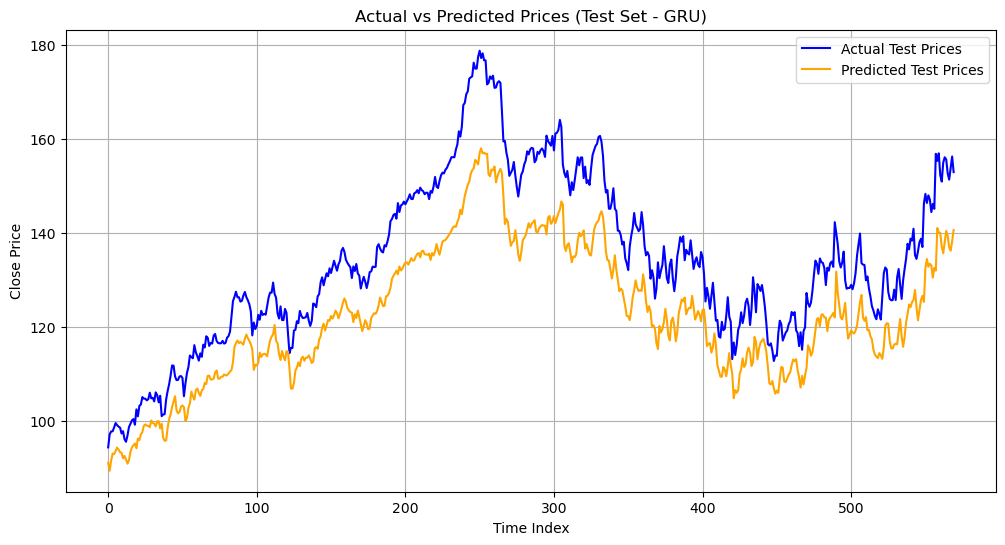

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error
import math

# Build the GRU model
model = Sequential([
    Input(shape=(t, X_train.shape[2])),  # Define input shape explicitly
    GRU(50, return_sequences=False),  # GRU with 50 units
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Make predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
train_actual = scaler.inverse_transform(np.hstack((train_data[t:-1, :-1], y_train.reshape(-1, 1))))[:, -1]
train_predictions_rescaled = scaler.inverse_transform(np.hstack((train_data[t:-1, :-1], train_predictions)))[:, -1]

val_actual = scaler.inverse_transform(np.hstack((val_data[t:-1, :-1], y_val.reshape(-1, 1))))[:, -1]
val_predictions_rescaled = scaler.inverse_transform(np.hstack((val_data[t:-1, :-1], val_predictions)))[:, -1]

test_actual = scaler.inverse_transform(np.hstack((test_data[t:-1, :-1], y_test.reshape(-1, 1))))[:, -1]
test_predictions_rescaled = scaler.inverse_transform(np.hstack((test_data[t:-1, :-1], test_predictions)))[:, -1]

# Calculate RMSE for each dataset
train_rmse = math.sqrt(mean_squared_error(train_actual, train_predictions_rescaled))
val_rmse = math.sqrt(mean_squared_error(val_actual, val_predictions_rescaled))
test_rmse = math.sqrt(mean_squared_error(test_actual, test_predictions_rescaled))

# Print RMSE for each dataset
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# Plot actual vs predicted values for the test dataset
plt.figure(figsize=(12, 6))
plt.plot(test_actual, label="Actual Test Prices", color="blue")
plt.plot(test_predictions_rescaled, label="Predicted Test Prices", color="orange")
plt.title("Actual vs Predicted Prices (Test Set - GRU)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()
